# Visualize the results

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os, re
import util

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib notebook

## Plot Embeddings

In [2]:
def restore_emb(config, train_dir):
    print 'Restoring graph...',
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('contextwise') and config['contextwise']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.all_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(train_dir)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            embeddings = sess.run(tf.all_variables())
    print 'done.'        
    if config.has_key('contextwise') and config['contextwise']:
        return embeddings[:3]
    else:
        return embeddings[0]

In [3]:
def get_2d_emb(embeddings, limit=None):
    print 'Reducing dimension...',
    if limit:
        embeddings = embeddings[2:limit+2] # skip <pad> and <unk>
    norm = np.sqrt(np.sum(np.square(embeddings), axis=0))
    normalized_embeddings = embeddings / norm
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(normalized_embeddings)
    print 'done.'
    return two_d_embeddings

In [4]:
def construct_emb_df(data_dir, two_d_embeddings):
    print 'Loading vocabulary...',
    vocab_path = os.path.join(data_dir, 'vocab.txt')
    word2id, _ = util.initialize_vocabulary(vocab_path)
    limit = len(two_d_embeddings)
    keys, values = word2id.keys()[2:limit+2], word2id.values()[2:limit+2]
    word = pd.DataFrame({'word': keys}, index=values)
    values = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
    emb_df = pd.concat([word, values], axis=1)
    emb_df = emb_df[pd.notnull(emb_df.x)]
    print 'done.'
    return emb_df

In [5]:
def merge_id(emb_df, lower=True):
    print 'Merging ids...',
    positive_df = pd.read_csv(os.path.join(data_dir, '..', 'positive_relations.tsv'),
                           sep='\t', index_col=0, encoding='utf-8')
    subj = positive_df[['subj', 'subj_qid']].rename_axis(
        {"subj": "entity", "subj_qid": "id"}, axis="columns")
    obj = positive_df[['obj', 'obj_qid']].rename_axis(
        {"obj": "entity", "obj_qid": "id"}, axis="columns")
    rel = positive_df[['rel', 'rel_id']].rename_axis(
        {"rel_id": "id"}, axis="columns")
    entity = pd.concat([subj, obj, rel], axis=0, ignore_index=True)
    if lower:
        entity['word'] = ['<' + w.lower() + '>' for w in entity['id']]
    else:
        entity['word'] = ['<' + w + '>' for w in entity['id']]
    entity = entity.drop_duplicates('word')
    merge_emb_df = emb_df.merge(entity[['entity', 'rel', 'word']], how='outer', on='word')
    print 'done.'
    return merge_emb_df

In [6]:
def plot_emb(dfs, colors, labels, anno=None, limit=None, 
             title='Embeddings', xlim=None, ylim=None):
    ax = dfs[0].plot(kind="scatter", 
            x='x', y='y', color=colors[0], legend=True, label=labels[0])
    ax = dfs[1].plot(kind="scatter", ax=ax, 
            x='x', y='y', color=colors[1], legend=True, label=labels[1])
    # annotate labels
    if anno:
        for index, row in dfs[1].iterrows():
            if limit and index % limit != 0:
                continue
            ax.annotate(row[anno], xy=(row['x'], row['y']))
            
    ax.set_xlabel('')
    ax.set_ylabel('')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(title)
    fig = ax.get_figure()
    return fig

### ER-CNN

<IPython.core.display.Javascript object>


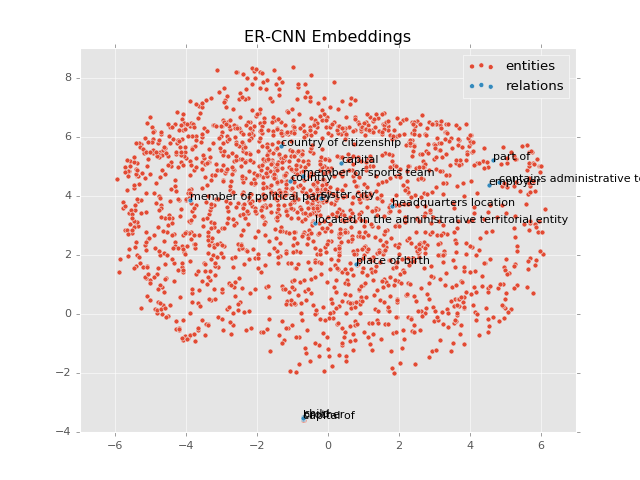

In [117]:
train_dir = os.path.join(os.getcwd(), 'train', '1474149092')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['entities', 'relations']

emb_er = restore_emb(config, train_dir)
two_d_emb_er = get_2d_emb(emb_er, limit=5000)
df_er = construct_emb_df(data_dir, two_d_emb_er)
emb_df_er = merge_id(df_er, lower=False)
dfs_er = [emb_df_er[pd.notnull(emb_df_er.entity)], 
          emb_df_er[pd.notnull(emb_df_er.rel)]]
fig_er = plot_emb(dfs_er, colors, labels, anno='rel', limit=None, 
                  title='ER-CNN Embeddings', xlim=(-7, 7), ylim=(-4, 9))
fig_er.savefig(os.path.join(train_dir, 'emb_er.pdf'))

### MLMI-CNN

<IPython.core.display.Javascript object>


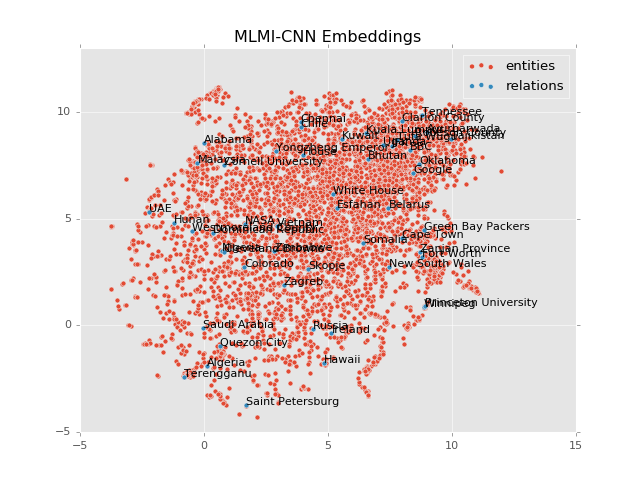

In [116]:
train_dir = os.path.join(os.getcwd(), 'train', '1474179389')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = config['data_dir']

emb_mlmi = restore_emb(config, train_dir)
two_d_emb_mlmi = get_2d_emb(emb_mlmi, limit=5000)
df_mlmi = construct_emb_df(data_dir, two_d_emb_mlmi)
emb_df_mlmi = merge_id(df_mlmi, lower=True)
dfs_mlmi = [emb_df_mlmi[pd.isnull(emb_df_mlmi.entity)], 
            emb_df_mlmi[pd.notnull(emb_df_mlmi.entity)]]
fig_mlmi = plot_emb(dfs_mlmi, colors, labels, anno='entity', 
                    limit=None, title='MLMI-CNN Embeddings', 
                    xlim=(-5, 15), ylim=(-5, 13))
fig_mlmi.savefig(os.path.join(train_dir, 'emb_mlmi.pdf'))

### MLMI-CONT

In [7]:
train_dir = os.path.join(os.getcwd(), 'train', '1474062134')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['entities', 'relations']

embeddings = restore_emb(config, train_dir)

Restoring graph... done.


<IPython.core.display.Javascript object>


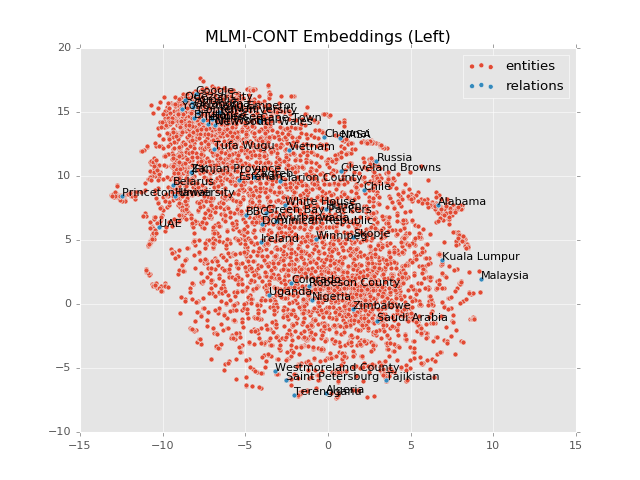

In [9]:
two_d_emb_left = get_2d_emb(embeddings[0], limit=5000)
emb_df_left = construct_emb_df(data_dir, two_d_emb_left)
emb_df_left = merge_id(emb_df_left, lower=True)
dfs_left = [emb_df_left[pd.isnull(emb_df_left.entity)], 
            emb_df_left[pd.notnull(emb_df_left.entity)]]
fig_left = plot_emb(dfs_left, colors, labels, anno='entity', limit=None,
                    title='MLMI-CONT Embeddings (Left)')
fig_left.savefig(os.path.join(train_dir, 'emb_left.pdf'))

<IPython.core.display.Javascript object>


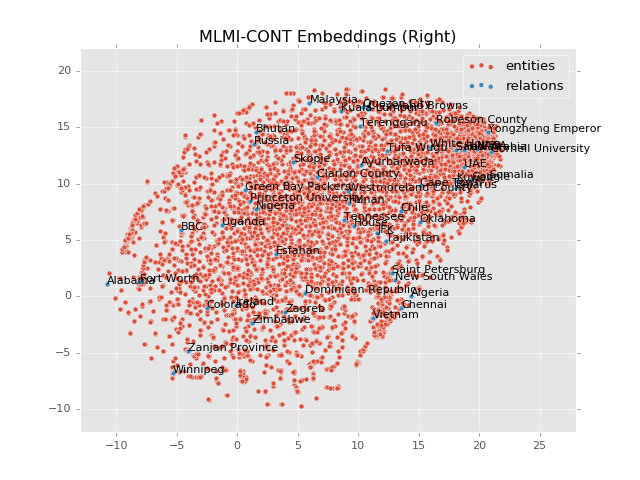

In [12]:
two_d_emb_right = get_2d_emb(embeddings[2], limit=5000)
emb_df_right = construct_emb_df(data_dir, two_d_emb_right)
emb_df_right = merge_id(emb_df_right, lower=True)
dfs_right = [emb_df_right[pd.isnull(emb_df_right.entity)], 
             emb_df_right[pd.notnull(emb_df_right.entity)]]
fig_right = plot_emb(dfs_right, colors, labels, anno='entity', 
                     limit=None, title='MLMI-CONT Embeddings (Right)', 
                     xlim=(-13, 28), ylim=(-12, 22))
fig_right.savefig(os.path.join(train_dir, 'emb_right.pdf'))

## Plot Precision-Recall Curve

In [2]:
def plot_pr_curve(train_dirs, colors, labels, xlim=None, ylim=None):
    
    for i, train_dir in enumerate(train_dirs):
        results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
        plt.plot(results['recall'], results['precision'], 'o-', 
                 color=colors[i], label=labels[i])
        
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.savefig(os.path.join(os.getcwd(), 'train', 'pr_curve.pdf'))

<IPython.core.display.Javascript object>


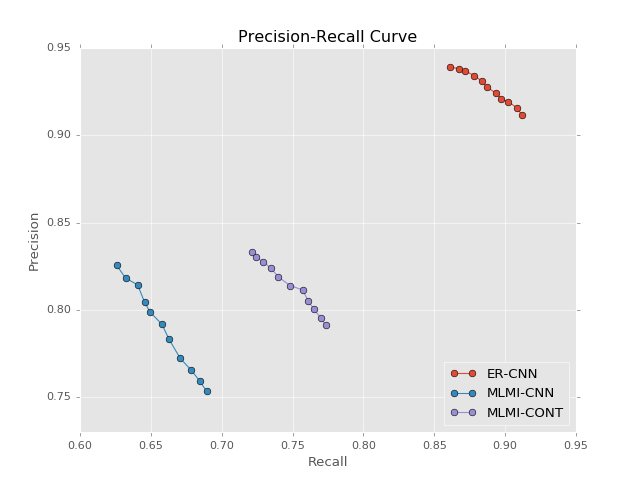

In [4]:
train_dirs = ['./train/1474149092', './train/1474179389', './train/1474062134']
colors = ['#E24A33', '#348ABD', '#988ED5']
labels = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
fig_auc = plot_pr_curve(train_dirs, colors, labels, ylim=(0.73, 0.95))

## Classification report

In [5]:
train_dirs = ['./train/1474149092', './train/1474179389', './train/1474062134']
models = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
print '             P     R    F1    AUC'
for i, train_dir in enumerate(train_dirs):
    results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
    pre = results['precision'][5]
    rec = results['recall'][5]
    f1 = (2.0 * pre * rec) / (pre + rec)
    auc = util.calc_auc_pr(results['precision'], results['recall'])
    print '%9s  %.2f  %.2f  %.2f  %.2f' % (models[i], pre, rec, f1, auc)

             P     R    F1    AUC
   ER-CNN  0.93  0.89  0.91  0.92
 MLMI-CNN  0.79  0.66  0.72  0.74
MLMI-CONT  0.81  0.75  0.78  0.79


In [17]:
def get_scores(config, data, train_dir):
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('contextwise') and config['contextwise']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.all_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(train_dir)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            predictions = []
            if config.has_key('contextwise') and config['contextwise']:
                left_batch, middle_batch, right_batch, y_batch, _ = zip(*data)
                feed = {m.left: np.array(left_batch),
                        m.middle: np.array(middle_batch),
                        m.right: np.array(right_batch),
                        m.labels: np.array(y_batch)}
            else:
                x_batch, y_batch, _ = zip(*data)
                feed = {m.inputs: np.array(x_batch), m.labels: np.array(y_batch)}
            prob = sess.run(m.scores, feed_dict=feed)
            for i in np.linspace(0, 1, 11):
                prediction = tf.select(prob > i, tf.ones_like(prob), tf.zeros_like(prob))
                predictions.append(prediction.eval())
            
    return np.array(predictions)

In [14]:
def report(y_true, y_pred, class_names):
    #y_pred = y_pred
    tp = np.logical_and(y_true, y_pred)
    fp = np.logical_and(np.logical_not(y_true), y_pred)
    fn = np.logical_and(y_true, np.logical_not(y_pred))
    pre = np.sum(tp.astype(float), axis=1)/np.sum(np.logical_or(tp, fp).astype(float), axis=1)
    rec = np.sum(tp.astype(float), axis=1)/np.sum(np.logical_or(tp, fn).astype(float), axis=1)
    f1 = (2.0 * pre * rec)/(pre + rec)
    count = np.sum(y_true, axis=0)
    auc_array = []
    ret = '          P \t  R \t  F1\t AUC\t  C\n'
    for i, (c, p, r, f, s) in enumerate(zip(class_names, pre[5], rec[5], f1[5], count)):
        auc = util.calc_auc_pr(pre[:, i], rec[:, i])
        auc_array.append(auc)
        ret += '%6s\t%.4f\t%.4f\t%.4f\t%.4f\t%4d\n' % (c, p, r, f, auc, s)
    
    auc = np.array(auc_array)
    p = pre[5, np.isfinite(pre[5])]*count[np.isfinite(pre[5])]
    r = rec[5, np.isfinite(rec[5])]*count[np.isfinite(rec[5])]
    f = f1[5, np.isfinite(f1[5])]*count[np.isfinite(f1[5])]
    a = auc[np.isfinite(auc)]*count[np.isfinite(auc)]
    ret += '%6s\t%.4f\t%.4f\t%.4f\t%.4f\t%4d\n' % ('total', 
         np.sum(p)/count.sum(dtype=float), 
         np.sum(r)/count.sum(dtype=float), 
         np.sum(f)/count.sum(dtype=float), 
         np.sum(a)/count.sum(dtype=float),
         count.sum())
    
    return ret

In [15]:
class_names = [u'P17', u'P131', u'P27', u'P47', u'P19', u'P150', u'P54', u'P20', 
               u'P1376', u'P69', u'P159', u'P530', u'P108', u'P26', u'P118', 
               u'P40', u'P36', u'P102', u'P361', u'P463', u'P190', u'P22', u'P7']

In [105]:
# MLMI-CNN
train_dir = os.path.join(os.getcwd(), 'train', '1474179389')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
source_path = os.path.join(config['data_dir'], "ids.txt")
target_path = os.path.join(config['data_dir'], "target.txt")
_, data = util.read_data(source_path, target_path, config['sent_len'],
                         train_size=config['train_size'])

y_true = np.array([y[1] for y in data])
y_pred = get_scores(config, data, train_dir)
print report(y_true, y_pred, class_names)

          P 	  R 	  F1	 AUC	  C
   P17	0.8097	0.8694	0.8385	0.8265	 651
  P131	0.8565	0.7705	0.8112	0.7981	 488
   P27	0.9000	0.3937	0.5478	0.6272	 160
   P47	0.7696	0.7867	0.7780	0.7705	 225
   P19	0.7500	0.2143	0.3333	0.4670	  56
  P150	0.5918	0.3867	0.4677	0.4609	  75
   P54	0.7857	0.8148	0.8000	0.7882	  27
   P20	0.5455	0.2308	0.3243	0.3873	  26
 P1376	0.8889	0.2807	0.4267	0.5413	  57
   P69	nan	0.0000	nan	nan	  22
  P159	0.8000	0.3429	0.4800	0.5603	  35
  P530	0.4615	0.6122	0.5263	0.5430	  49
  P108	0.5000	0.0714	0.1250	0.0542	  14
   P26	0.8571	0.2727	0.4138	0.5373	  22
  P118	1.0000	0.5926	0.7442	0.7407	  27
   P40	0.5000	0.1250	0.2000	0.2854	  16
   P36	0.3333	0.0526	0.0909	0.2684	  19
  P102	nan	0.0000	nan	nan	  17
  P361	0.0833	0.1111	0.0952	0.0969	   9
  P463	0.6667	0.1333	0.2222	nan	  15
  P190	nan	0.0000	nan	nan	   7
   P22	nan	0.0000	nan	nan	  10
    P7	0.0000	0.0000	nan	0.0000	   7
 total	0.7686	0.6578	0.6859	0.6950	2034



In [18]:
# MLMI-CONT
train_dir = os.path.join(os.getcwd(), 'train', '1474062134')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
source_path = os.path.join(config['data_dir'], "ids")
target_path = os.path.join(config['data_dir'], "target.txt")
_, data = util.read_data_contextwise(source_path, target_path, config['sent_len'], 
                                     train_size=config['train_size'])

y_true = np.array([y[3] for y in data])
y_pred = get_scores(config, data, train_dir)
print report(y_true, y_pred, class_names)

          P 	  R 	  F1	 AUC	  C
   P17	0.8513	0.9585	0.9017	0.8967	 651
  P131	0.9099	0.6414	0.7524	0.7600	 488
   P27	0.5714	0.8500	0.6834	0.6829	 160
   P47	0.8034	0.8356	0.8192	0.8043	 225
   P19	0.8387	0.4643	0.5977	0.6302	  56
  P150	0.9483	0.7333	0.8271	0.8153	  75
   P54	0.9000	0.6667	0.7660	0.7152	  27
   P20	0.8000	0.1538	0.2581	0.4312	  26
 P1376	0.8605	0.6491	0.7400	0.7606	  57
   P69	0.8750	0.3182	0.4667	0.6016	  22
  P159	0.8462	0.3143	0.4583	0.5579	  35
  P530	0.6866	0.9388	0.7931	0.7975	  49
  P108	0.0000	0.0000	nan	nan	  14
   P26	0.7500	0.2727	0.4000	0.6023	  22
  P118	1.0000	0.8148	0.8980	0.8704	  27
   P40	0.5556	0.6250	0.5882	0.5591	  16
   P36	0.8333	0.2632	0.4000	0.5216	  19
  P102	1.0000	0.1176	0.2105	0.5294	  17
  P361	1.0000	0.1111	0.2000	0.5185	   9
  P463	0.8000	0.5333	0.6400	0.7133	  15
  P190	nan	0.0000	nan	nan	   7
   P22	0.5000	0.1000	0.1667	0.3000	  10
    P7	0.3333	0.2857	0.3077	0.2262	   7
 total	0.8253	0.7483	0.7606	0.7726	2034



## Plot Train Log

In [19]:
def plot_log(train_dirs, colors, models, name, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(1, 1)
    for i, train_dir in enumerate(train_dirs):
        train = pd.read_csv(os.path.join(train_dir, 'train_%s.csv' % name),
            index_col=1, names=['time', 'train_%s' % models[i]], skiprows=[0])
        dev = pd.read_csv(os.path.join(train_dir, 'dev_%s.csv' % name), 
            index_col=1, names=['time', 'dev_%s' % models[i]], skiprows=[0])      
        
        ax = train['train_%s' % models[i]].plot(style='--', legend=True, 
                                                color=colors[i], ax=ax)
        ax = dev['dev_%s' % models[i]].plot(legend=True, 
                                            color=colors[i], ax=ax)
        ax.set_xlabel('Step')
        ax.set_ylabel(name.upper())
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.set_title(name.upper())
    return fig

<IPython.core.display.Javascript object>


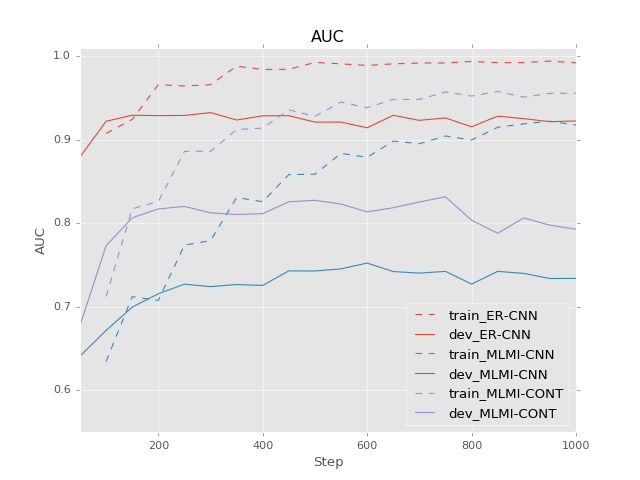

In [20]:
train_dirs = ['./train/1474149092', './train/1474179389', './train/1474062134']
colors = ['#E24A33', '#348ABD', '#988ED5']
models = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
fig_auc = plot_log(train_dirs, colors, models, 'auc', 
                   xlim=(50, 1000), ylim=(0.55, 1.01))
fig_auc.savefig(os.path.join(os.getcwd(), 'train', 'auc.pdf'))

<IPython.core.display.Javascript object>


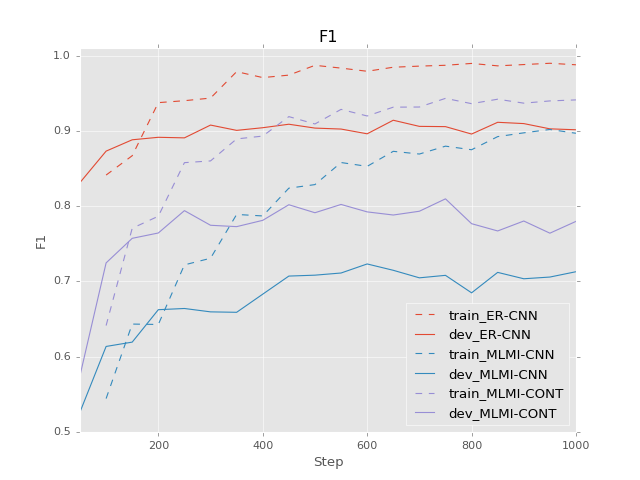

In [21]:
fig_f1 = plot_log(train_dirs, colors, models, 'f1', 
                  xlim=(50, 1000), ylim=(0.5, 1.01))
fig_f1.savefig(os.path.join(os.getcwd(), 'train', 'f1.pdf'))

<IPython.core.display.Javascript object>


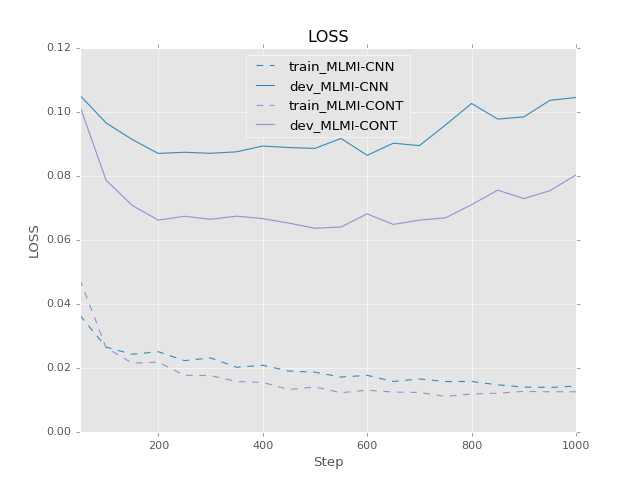

In [22]:
train_dirs = ['./train/1474179389', './train/1474062134']
colors = ['#348ABD', '#988ED5']
models = ['MLMI-CNN', 'MLMI-CONT']
fig_loss = plot_log(train_dirs, colors, models, 'loss')
fig_loss.savefig(os.path.join(os.getcwd(), 'train', 'loss.pdf'))